# ERA SST Trends

In [47]:
import xarray as xr
import json
import gcsfs
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

## Read in nc files and upload single sst ds to zarr

In [ ]:
ds_uncleaned = xr.open_mfdataset('era/*.nc', engine='netcdf4')
ds_dropped = (ds_uncleaned.drop_vars(('number', 'expver')) - 273.15)
ds = ds_dropped.rename_dims({'valid_time':'time'})

In [ ]:
ds

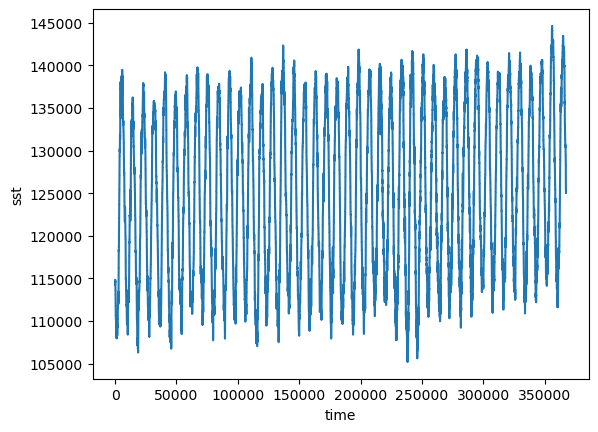

In [21]:
ds.sst.sum(['latitude', 'longitude']).plot()

In [39]:
ds.chunk({'latitude':-1, 'longitude':-1, 'time':11}).nbytes/1e9

9.466933208

In [38]:
ds.chunk({'latitude':-1, 'longitude':-1, 'time':11})

<xarray.Dataset> Size: 9GB
Dimensions:     (time: 367334, latitude: 57, longitude: 113)
Coordinates:
  * valid_time  (time) datetime64[ns] 3MB 1983-01-01 ... 2024-11-26T13:00:00
  * latitude    (latitude) float64 456B 31.0 30.75 30.5 ... 17.5 17.25 17.0
  * longitude   (longitude) float64 904B -100.0 -99.75 -99.5 ... -72.25 -72.0
Dimensions without coordinates: time
Data variables:
    sst         (time, latitude, longitude) float32 9GB dask.array<chunksize=(11, 57, 113), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-30T21:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [40]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/GFDL/sst-1983_2024.zarr')
ds.chunk({'latitude':-1, 'longitude':-1, 'time':11}).to_zarr(gcsmap, mode='w')

Delete `.nc` files once upload to zarr is complete to free up LEAP data storage

## Recreate Figure 2 e)-h) panels in [Feng et al., 2023](https://www.sciencedirect.com/science/article/pii/S1674927823000953?via%3Dihub) paper

In [3]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/GFDL/sst-1983_2024.zarr'))

In [5]:
ds.load()

<xarray.Dataset> Size: 9GB
Dimensions:     (latitude: 57, longitude: 113, time: 367334)
Coordinates:
  * latitude    (latitude) float64 456B 31.0 30.75 30.5 ... 17.5 17.25 17.0
  * longitude   (longitude) float64 904B -100.0 -99.75 -99.5 ... -72.25 -72.0
    valid_time  (time) datetime64[ns] 3MB 1983-01-01 ... 2024-11-26T13:00:00
Dimensions without coordinates: time
Data variables:
    sst         (time, latitude, longitude) float32 9GB nan nan ... 29.05 29.11
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    history:                 2024-11-30T21:21 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [43]:
ds_r = ds.assign_coords({'time':ds.time.valid_time}).drop_vars('valid_time')
sst_feng = ds_r.sst.sel(longitude=slice(-98, -81.3), latitude=slice(None, 17.5), time=slice(None, '2021'))

In [42]:
sst_feng

<xarray.DataArray 'sst' (time: 341880, latitude: 55, longitude: 67)> Size: 5GB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 27.090973, 27.125153,
         27.163239],
        [      nan,       nan,       nan, ..., 27.106598, 27.113434,
         27.15152 ],
        [      nan,       nan,       nan, ..., 27.107574, 27.115387,
         27.138824]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ..., 27.884186, 27.893951,
         27.862701],
        [      nan,       nan,       nan, ..., 27.863678, 27.890045,
         27.86856 ],
        [      nan,       nan,       nan, ..., 27.857819, 27.894928,
         27.90274 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 27.884186, 27.893951,
         27.862701],
        [      nan,       nan,       nan, ..., 27.863678, 27.890045,
         27.86856 ],
        [      nan,       nan,       nan, ..., 27.857819, 27.894928,
         27.90274 ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 440B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float64 536B -98.0 -97.75 -97.5 ... -81.75 -81.5
  * time       (time) datetime64[ns] 3MB 1983-01-01 ... 2021-12-31T23:00:00

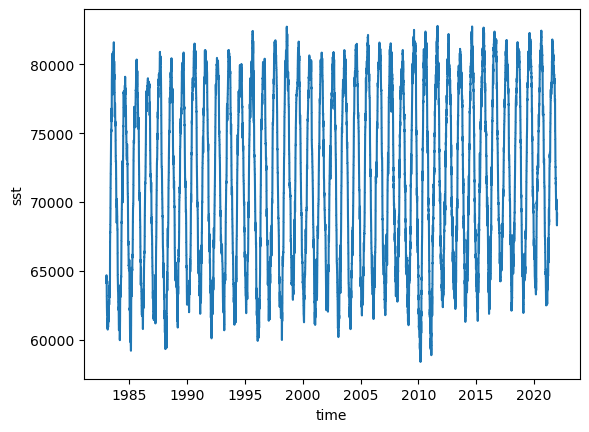

In [44]:
sst_feng.sum(['latitude', 'longitude']).plot()

In [59]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend = linregress(np.arange(0,341880), sst_feng.mean(['latitude', 'longitude']).fillna(0.))

In [60]:
trend

LinregressResult(slope=np.float64(2.7950423914029307e-06), intercept=np.float64(25.900823647399427), rvalue=np.float64(0.11202105757407596), pvalue=np.float64(0.0), stderr=np.float64(4.240440682130549e-08), intercept_stderr=np.float64(0.008369954701910457))

In [61]:
trend_line = (trend[0]*np.arange(0,341880) + trend[1])

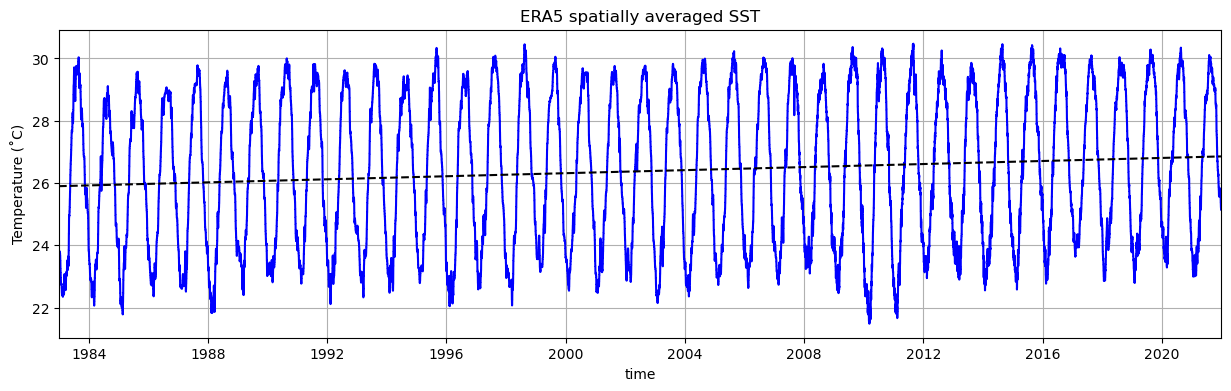

In [64]:
sst_feng.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst_feng.time, trend_line, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst_feng.time.sel(time='1983-01-01', method='nearest'), 
         sst_feng.time.sel(time='2021-12-31', method='nearest'))
plt.title('ERA5 spatially averaged SST');

In [68]:
print('Spatially averaged rate of SST increase over 1983-2021:', 
      (trend_line[-1] - trend_line[0]) / (2021-1983), 
      '˚C/yr')

Spatially averaged rate of SST increase over 1983-2021: 0.025146481519222164 ˚C/yr


### Mask out SST < SST(90$^{th}$ threshold)

In [70]:
#resample to daily to get rid of diurnal cycle
sst_r = sst_feng.resample(time='D').mean()
sst_clim = sst_r.groupby('time.dayofyear').mean('time')
sst_anom = sst_r.groupby('time.dayofyear') - sst_clim

#only keep May-Oct months
may_oct = sst_anom.sel(time=sst_anom.time.dt.month.isin([5, 6, 7, 8, 9, 10]))
anom_may_oct = sst_anom.where(sst_anom.time==may_oct.time)

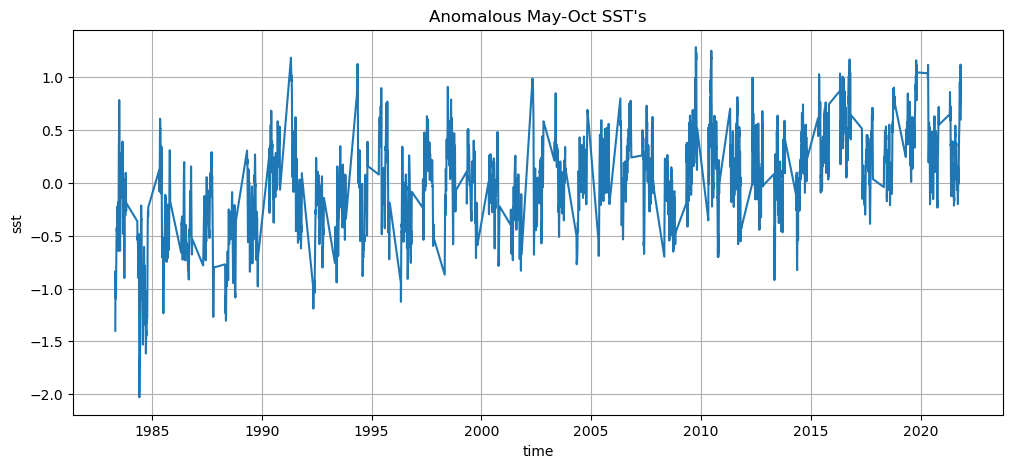

In [79]:
anom_may_oct.mean(['latitude', 'longitude']).plot(figsize=(12,5))
plt.grid()
plt.title("Anomalous May-Oct SST's");

In [80]:
q90 = sst_feng.quantile(0.90, dim='time')

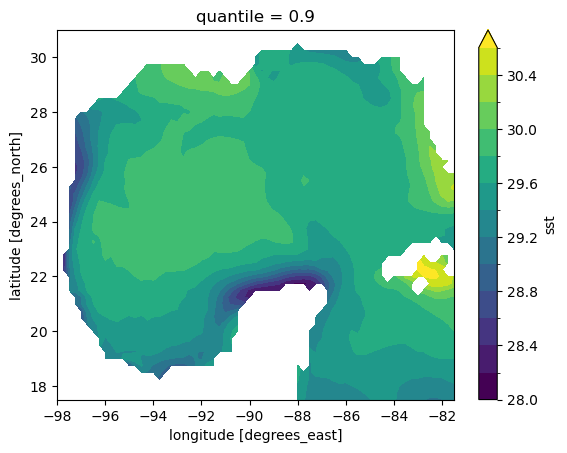

In [89]:
q90.plot.contourf(levels=np.arange(28,30.6,0.2))